In [3]:

import torch
from pathlib import Path
import shutil
import numpy as np
import os

from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms,datasets,models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import ImageEnhance

c:\Users\chess\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chess\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\chess/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 48.0MB/s]


Epoch 1, Training Loss: 0.9938561022281647, Training Accuracy: 63.492063492063494%
Epoch 1, Test Loss: 10.347822785377502, Test Accuracy: 37.83783783783784%
Epoch 2, Training Loss: 0.28350713503147873, Training Accuracy: 92.06349206349206%
Epoch 2, Test Loss: 0.4971650466322899, Test Accuracy: 82.88288288288288%
Epoch 3, Training Loss: 0.1093052684196404, Training Accuracy: 97.27891156462584%
Epoch 3, Test Loss: 0.6074897013604641, Test Accuracy: 82.88288288288288%
Epoch 4, Training Loss: 0.04675999247202916, Training Accuracy: 98.86621315192744%
Epoch 4, Test Loss: 0.30267155542969704, Test Accuracy: 89.1891891891892%
Epoch 5, Training Loss: 0.05270030126640839, Training Accuracy: 98.63945578231292%
Epoch 5, Test Loss: 1.5414654165506363, Test Accuracy: 73.87387387387388%
Epoch 6, Training Loss: 0.13778800923111184, Training Accuracy: 95.01133786848072%
Epoch 6, Test Loss: 0.3058980777859688, Test Accuracy: 90.09009009009009%
Epoch 7, Training Loss: 0.10031302965113095, Training Accur

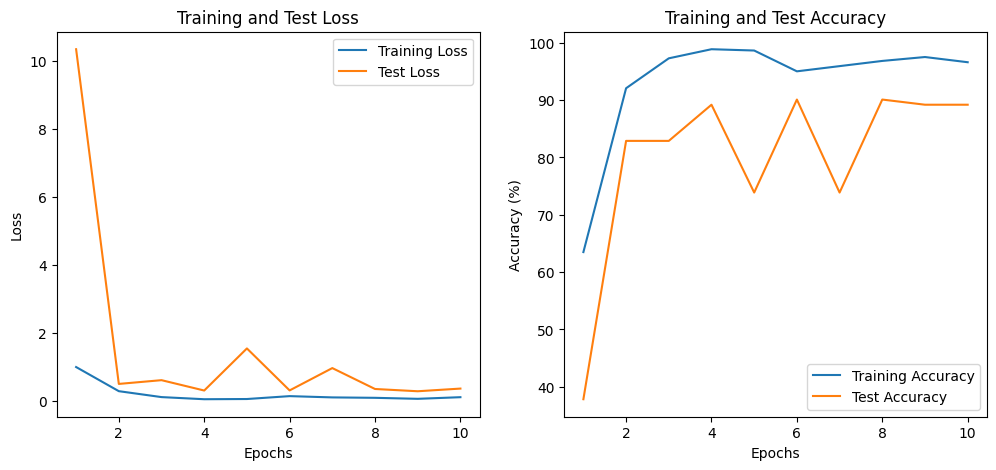

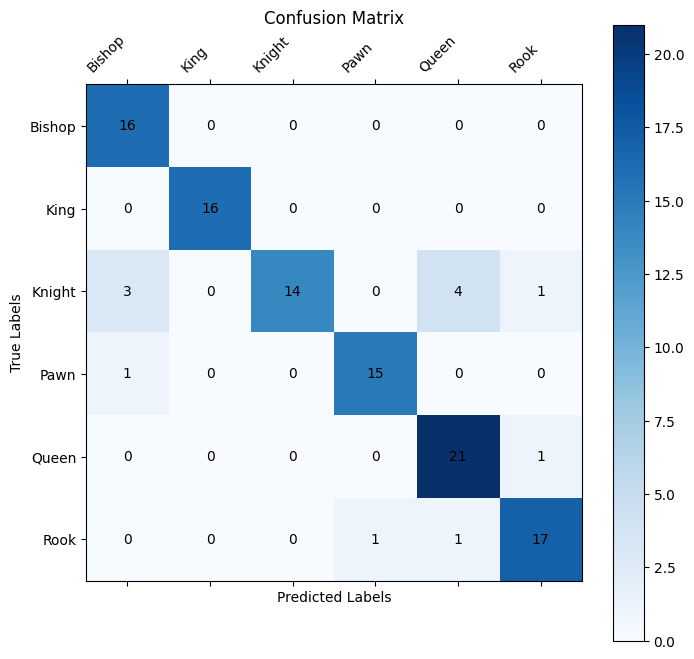

In [4]:
def crop_top(img):
    width, height = img.size
    return img.crop((0, 0, width, int(height * 0.6)))

transform = transforms.Compose([
    transforms.Lambda(crop_top),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_path = 'data/raw/Chess'

full_data = datasets.ImageFolder(root=data_path, transform=transform)

train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size
train_data, test_data = random_split(full_data, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(full_data.classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {100 * correct / total}%")

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch + 1}, Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {100 * correct / total}%")

# Gráfica de pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

# Gráfica de precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy")
plt.legend()

plt.show()


# Crear matriz de confusión
num_classes = len(full_data.classes)
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(all_labels, all_preds):
    confusion_matrix[true_label, pred_label] += 1
# Graficar matriz de confusión
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(confusion_matrix, cmap='Blues')
plt.colorbar(cax)
# Añadir etiquetas a la gráfica
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(full_data.classes, rotation=45, ha="right")
ax.set_yticklabels(full_data.classes)
# Añadir los valores de cada celda en la matriz
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
